
<a id='mccall-with-sep'></a>
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Job Search II: Search and Separation


<a id='index-0'></a>

## Contents

- [Job Search II: Search and Separation](#Job-Search-II:-Search-and-Separation)  
  - [Overview](#Overview)  
  - [The model](#The-model)  
  - [Solving the model](#Solving-the-model)  
  - [Code](#Code)  
  - [A simplifying transformation](#A-simplifying-transformation)  
  - [Implementation](#Implementation)  
  - [Impact of parameters](#Impact-of-parameters)  
  - [Exercises](#Exercises)  

In addition to what’s in Anaconda, this lecture will need the following libraries:

In [ ]:
!pip install quantecon jax myst-nb

## Overview

Previously [we looked](https://python.quantecon.org/mccall_model.html) at the McCall job search model [[McCall, 1970](https://python.quantecon.org/zreferences.html#id208)] as a way of understanding unemployment and worker decisions.

One unrealistic feature of that version of the model was that every job is permanent.

In this lecture, we extend the model by introducing job separation.

Once separation enters the picture, the agent comes to view

- the loss of a job as a capital loss, and  
- a spell of unemployment as an *investment* in searching for an acceptable job  


The other minor addition is that a utility function will be included to make
worker preferences slightly more sophisticated.

We’ll need the following imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from typing import NamedTuple
from quantecon.distributions import BetaBinomial
from myst_nb import glue

## The model

The model is similar to the [baseline McCall job search model](https://python.quantecon.org/mccall_model.html).

It concerns the life of an infinitely lived worker and

- the opportunities he or she (let’s say he to save one character) has to work at different wages  
- exogenous events that destroy his current job  
- his decision making process while unemployed  


The worker can be in one of two states: employed or unemployed.

He wants to maximize


<a id='equation-objective'></a>
$$
{\mathbb E} \sum_{t=0}^\infty \beta^t u(y_t) \tag{43.1}
$$

At this stage the only difference from the [baseline model](https://python.quantecon.org/mccall_model.html) is that we’ve added some flexibility to preferences by
introducing a utility function $ u $.

It satisfies $ u'> 0 $ and $ u'' < 0 $.

Wage offers $ \{ W_t \} $ are IID with common distribution $ q $.

The set of possible wage values is denoted by $ \mathbb W $.

### Timing and decisions

At the start of each period, the agent can be either

- unemployed or  
- employed at some existing wage level $ w $.  


If currently employed at wage $ w $, the worker

1. receives utility $ u(w) $ from their current wage and  
1. is fired with some (small) probability $ \alpha $, becoming unemployed next period.  


If currently unemployed, the worker receives random wage offer $ W_t $ and either accepts or rejects.

If he accepts, then he begins work immediately at wage $ W_t $.

If he rejects, then he receives unemployment compensation $ c $.

The process then repeats.

>**Note**
>
>We do not allow for job search while employed—this topic is taken up in a [later lecture](https://python.quantecon.org/jv.html).

## Solving the model

We drop time subscripts in what follows and primes denote next period values.

Let

- $ v_e(w) $ be maximum lifetime value for a worker who enters the current
  period employed with wage $ w $  
- $ v_u(w) $ be maximum lifetime for a worker who who enters the
  current period unemployed and receives wage offer $ w $.  


Here, **maximum lifetime value** means the value of [(43.1)](#equation-objective) when
the worker makes optimal decisions at all future points in time.

As we now show, obtaining these functions is key to solving the model.

### The Bellman equations

We recall that, in [the original job search model](https://python.quantecon.org/mccall_model.html), the
value function (the value of being unemployed with a given wage offer) satisfied
a Bellman equation.

Here this function again satisfies a Bellman equation that looks very similar.


<a id='equation-bell2-mccall'></a>
$$
v_u(w) = \max 
        \left\{ 
            v_e(w), \,  
            u(c) + \beta \sum_{w' \in \mathbb W} v_u(w') q(w') 
        \right\} \tag{43.2}
$$

The difference is that the value of accepting is $ v_e(w) $ rather than
$ w/(1-\beta) $.

We have to make this change because jobs are not permanent.

Accepting transitions the worker to employment and hence yields reward $ v_e(w) $,
which we discuss below.

Rejecting leads to unemployment compensation and unemployment tomorrow.

Equation [(43.2)](#equation-bell2-mccall) expresses the value of being unemployed with offer
$ w $ in hand as a maximum over the value of two options: accept or reject
the current offer.

The function $ v_e $ also satisfies a Bellman equation:


<a id='equation-bell1-mccall'></a>
$$
v_e(w) = u(w) + \beta
        \left[
            (1-\alpha)v_e(w) + \alpha \sum_{w' \in \mathbb W} v_u(w') q(w')
        \right] \tag{43.3}
$$

>**Note**
>
>This equation differs from a traditional Bellman equation because there is no max.

There is no max because an employed agent has no choices.

Nonetheless, in keeping with most of the literature, we also refer to it as a
Bellman equation.

Equation [(43.3)](#equation-bell1-mccall) expresses the value of being employed at wage $ w $ in terms of

- current reward $ u(w) $ plus  
- discounted expected reward tomorrow, given the $ \alpha $ probability of being fired  


As we will see, equations [(43.3)](#equation-bell1-mccall) and [(43.2)](#equation-bell2-mccall) provide
enough information to solve for both $ v_e $ and $ v_u $.

Once we have them in hand, we will be able to make optimal choices.

### The reservation wage

Let


<a id='equation-defh-mm'></a>
$$
h := u(c) + \beta \sum_{w' \in \mathbb W} v_u(w') q(w') \tag{43.4}
$$

This is the **continuation value** for an unemployed agent – the value of rejecting the current offer and then making optimal choices.

From [(43.2)](#equation-bell2-mccall), we see that an unemployed agent accepts current offer $ w $ if $ v_e(w) \geq h $.

This means precisely that the value of accepting is higher than the value of rejecting.

The function $ v_e $ is increasing in $ w $, since an employed agent is never made worse off by a higher current wage.

Hence, we can express the optimal choice as accepting wage offer $ w $ if and only if $ w \geq \bar w $,
where the **reservation wage** $ \bar w $ is the first wage level $ w \in \mathbb W $ such that

$$
v_e(w) \geq h
$$

## Code

Let’s now implement a solution method based on the two Bellman equations
[(43.2)](#equation-bell2-mccall) and [(43.3)](#equation-bell1-mccall).

### Set up

The default utility function is a CRRA utility function

In [ ]:
def u(x, γ):
    return (x**(1 - γ) - 1) / (1 - γ)

Also, here’s a default wage distribution, based around the BetaBinomial
distribution:

In [ ]:
n = 60                                  # n possible outcomes for w
w_default = jnp.linspace(10, 20, n)     # wages between 10 and 20
a, b = 600, 400                         # shape parameters
dist = BetaBinomial(n-1, a, b)          # distribution
q_default = jnp.array(dist.pdf())       # probabilities as a JAX array

Here’s our model class for the McCall model with separation.

In [ ]:
class Model(NamedTuple):
    α: float = 0.2              # job separation rate
    β: float = 0.98             # discount factor
    γ: float = 2.0              # utility parameter (CRRA)
    c: float = 6.0              # unemployment compensation
    w: jnp.ndarray = w_default  # wage outcome space
    q: jnp.ndarray = q_default  # probabilities over wage offers

### Operators

We’ll use a similar iterative approach to solving the Bellman equations that we
adopted in the [first job search lecture](https://python.quantecon.org/mccall_model.html).

As a first step, to iterate on the Bellman equations, we define two operators, one for each value function.

These operators take the current value functions as inputs and return updated versions.

In [ ]:
def T_u(model, v_u, v_e):
    """
    Apply the unemployment Bellman update rule and return new guess of v_u.

    """
    α, β, γ, c, w, q = model
    h = u(c, γ) + β * (v_u @ q)
    v_u_new = jnp.maximum(v_e, h)
    return v_u_new

In [ ]:
def T_e(model, v_u, v_e):
    """
    Apply the employment Bellman update rule and return new guess of v_e.

    """
    α, β, γ, c, w, q = model
    v_e_new = u(w, γ) + β * ((1 - α) * v_e + α * (v_u @ q))
    return v_e_new

### Iteration

Now we write an iteration routine, which updates the pair of arrays  $ v_u $, $ v_e $ until convergence.

More precisely, we iterate until successive realizations are closer together
than some small tolerance level.

In [ ]:
def solve_full_model(
        model,
        tol: float = 1e-6,
        max_iter: int = 1_000,
    ):
    """
    Solves for both value functions v_u and v_e iteratively.

    """
    α, β, γ, c, w, q = model
    i = 0
    error = tol + 1
    v_e = v_u = w / (1 - β)

    while i < max_iter and error > tol:
        v_u_next = T_u(model, v_u, v_e)
        v_e_next = T_e(model, v_u, v_e)
        error_u = jnp.max(jnp.abs(v_u_next - v_u))
        error_e = jnp.max(jnp.abs(v_e_next - v_e))
        error = jnp.max(jnp.array([error_u, error_e]))
        v_u = v_u_next
        v_e = v_e_next
        i += 1

    return v_u, v_e

### Computing the reservation wage

Now that we can solve for both value functions, let’s investigate the reservation wage.

Recall from above that the reservation wage $ \bar w $ is the first $ w \in \mathbb
W $ satisfying $ v_e(w) \geq h $, where $ h $ is the continuation value defined in [(43.4)](#equation-defh-mm).

Let’s compare $ v_e $ and $ h $ to see what they look like.

We’ll use the default parameterizations found in the code above.

In [ ]:
model = Model()
α, β, γ, c, w, q = model
v_u, v_e = solve_full_model(model)
h = u(c, γ) + β * (v_u @ q)

fig, ax = plt.subplots()
ax.plot(w, v_e, 'b-', lw=2, alpha=0.7, label='$v_e$')
ax.plot(w, [h] * len(w), 'g-', lw=2, alpha=0.7, label='$h$')
ax.set_xlim(min(w), max(w))
ax.legend()
plt.show()

The value $ v_e $ is increasing because higher $ w $ generates a higher wage flow conditional on staying employed.

The reservation wage is the $ w $ where these lines meet.

Let’s compute this reservation wage explicitly:

In [ ]:
def compute_reservation_wage_full(model):
    """
    Computes the reservation wage using the full model solution.
    """
    α, β, γ, c, w, q = model
    v_u, v_e = solve_full_model(model)
    h = u(c, γ) + β * (v_u @ q)
    # Find the first w such that v_e(w) >= h, or +inf if none exist
    accept = v_e >= h
    i = jnp.argmax(accept)  # returns first accept index
    w_bar = jnp.where(jnp.any(accept), w[i], jnp.inf)
    return w_bar

w_bar_full = compute_reservation_wage_full(model)
print(f"Reservation wage (full model): {w_bar_full:.4f}")

This value seems close to where the two lines meet.


<a id='ast-mcm'></a>

## A simplifying transformation

The approach above works, but iterating over two vector-valued functions is computationally expensive.

With some mathematics and some brain power, we can form a solution method that
is far more efficient.

(This process will be analogous to our [second pass](https://python.quantecon.org/mccall_model.html#mm-op2) at the plain vanilla
McCall model, where we reduced the Bellman equation to an equation in an unknown
scalar value, rather than an unknown vector.)

First, we use the continuation value $ h $, as defined in [(43.4)](#equation-defh-mm), to write [(43.2)](#equation-bell2-mccall) as

$$
v_u(w) = \max \left\{ v_e(w), \,  h \right\}
$$

Taking the expectation of both sides and then discounting, this becomes

$$
\beta \sum_{w'} v_u(w') q(w')
 = \beta \sum_{w'} \max \left\{ v_e(w'), \,  h \right\} q(w')
$$

Adding $ u(c) $ to both sides and using [(43.4)](#equation-defh-mm) again gives


<a id='equation-bell02-mccall'></a>
$$
h = u(c) + \beta \sum_{w'} \max \left\{ v_e(w'), \,  h \right\} q(w') \tag{43.5}
$$

This is a nice scalar equation in the continuation value, which is already
useful.

But we can go further, but eliminating $ v_e $ from the above equation.

### Simplifying to a single equation

As a first step, we rearrange the expression defining $ h $ (see [(43.4)](#equation-defh-mm)) to obtain

$$
\sum_{w'} v_u(w') q(w') = \frac{h - u(c)}{\beta}
$$

Using this, the Bellman equation for $ v_e $, as given in [(43.3)](#equation-bell1-mccall), can now be rewritten as


<a id='equation-bell01-mccall'></a>
$$
v_e(w) = u(w) + \beta
    \left[
        (1-\alpha)v_e(w) + \alpha \frac{h - u(c)}{\beta}
    \right] \tag{43.6}
$$

Our next step is to solve [(43.6)](#equation-bell01-mccall) for $ v_e $ as a function of $ h $.

Rearranging [(43.6)](#equation-bell01-mccall) gives

$$
v_e(w) = u(w) + \beta(1-\alpha)v_e(w) + \alpha(h - u(c))
$$

or

$$
v_e(w) - \beta(1-\alpha)v_e(w) = u(w) + \alpha(h - u(c))
$$

Solving for $ v_e(w) $ gives


<a id='equation-v-e-closed'></a>
$$
v_e(w) = \frac{u(w) + \alpha(h - u(c))}{1 - \beta(1-\alpha)} \tag{43.7}
$$

Substituting this into [(43.5)](#equation-bell02-mccall) yields


<a id='equation-bell-scalar'></a>
$$
h = u(c) + \beta \sum_{w' \in \mathbb W} \max \left\{ \frac{u(w') + \alpha(h - u(c))}{1 - \beta(1-\alpha)}, \,  h \right\} q(w') \tag{43.8}
$$

Finally we have a single scalar equation in $ h $!

If we can solve this for $ h $, we can easily recover $ v_e $ using
[(43.7)](#equation-v-e-closed).

Then we have enough information to compute the reservation wage.

### Solving the Bellman equations

To solve [(43.8)](#equation-bell-scalar), we use the iteration rule


<a id='equation-bell-iter'></a>
$$
h_{n+1} = u(c) + \beta \sum_{w' \in \mathbb W}
    \max \left\{ \frac{u(w') + \alpha(h_n - u(c))}{1 - \beta(1-\alpha)}, \,  h_n \right\} q(w') \tag{43.9}
$$

starting from some initial condition $ h_0 $.

(It is possible to prove that [(43.9)](#equation-bell-iter) converges via the Banach contraction mapping theorem.)

## Implementation

To implement iteration on $ h $, we provide a function that provides one update,
from $ h_n $ to $ h_{n+1} $

In [ ]:
def update_h(model, h):
    " One update of the scalar h. "
    α, β, γ, c, w, q = model
    v_e = compute_v_e(model, h)
    h_new = u(c, γ) + β * (jnp.maximum(v_e, h) @ q)
    return h_new

Also, we provide a function to compute $ v_e $ from [(43.7)](#equation-v-e-closed).

In [ ]:
def compute_v_e(model, h):
    " Compute v_e from h using the closed-form expression. "
    α, β, γ, c, w, q = model
    return (u(w, γ) + α * (h - u(c, γ))) / (1 - β * (1 - α))

This function will be applied once convergence is achieved.

Now we can write our model solver.

In [ ]:
@jax.jit
def solve_model(model, tol=1e-5, max_iter=2000):
    " Iterates to convergence on the Bellman equations. "

    def cond(loop_state):
        h, i, error = loop_state
        return jnp.logical_and(error > tol, i < max_iter)

    def update(loop_state):
        h, i, error = loop_state
        h_new = update_h(model, h)
        error_new = jnp.abs(h_new - h)
        return h_new, i + 1, error_new

    # Initialize
    h_init = u(model.c, model.γ) / (1 - model.β)
    i_init = 0
    error_init = tol + 1
    init_state = (h_init, i_init, error_init)

    final_state = jax.lax.while_loop(cond, update, init_state)
    h_final, _, _ = final_state

    # Compute v_e from the converged h
    v_e_final = compute_v_e(model, h_final)

    return v_e_final, h_final

Finally, here’s a function `compute_reservation_wage` that uses all the logic above,
taking an instance of `Model` and returning the associated reservation wage.

In [ ]:
def compute_reservation_wage(model):
    """
    Computes the reservation wage of an instance of the McCall model
    by finding the smallest w such that v_e(w) >= h.

    """
    # Find the first i such that v_e(w_i) >= h and return w[i]
    # If no such w exists, then w_bar is set to np.inf
    v_e, h = solve_model(model)
    accept = v_e >= h
    i = jnp.argmax(accept)   # take first accept index
    w_bar = jnp.where(jnp.any(accept), model.w[i], jnp.inf)
    return w_bar

Let’s verify that this simplified approach gives the same answer as the full model:

In [ ]:
w_bar_simplified = compute_reservation_wage(model)
print(f"Reservation wage (simplified): {w_bar_simplified:.4f}")
print(f"Reservation wage (full model): {w_bar_full:.4f}")
print(f"Difference: {abs(w_bar_simplified - w_bar_full):.6f}")

As we can see, both methods produce essentially the same reservation wage.

However, the simplified method is far more efficient.

Next we will investigate how the reservation wage varies with parameters.

## Impact of parameters

In each instance below, we’ll show you a figure and then ask you to reproduce it in the exercises.

### The reservation wage and unemployment compensation

First, let’s look at how $ \bar w $ varies with unemployment compensation.

In the figure below, we use the default parameters in the `Model` class, apart from
c (which takes the values given on the horizontal axis)

![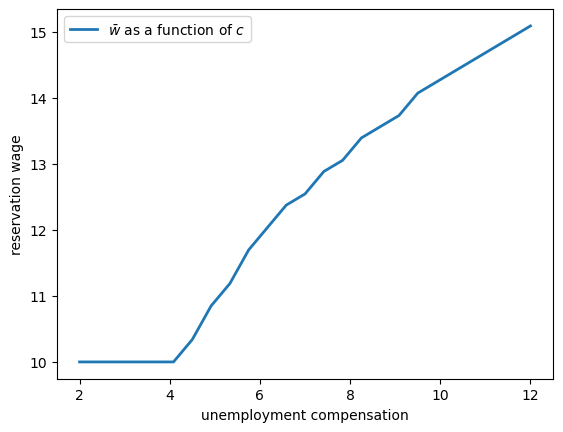](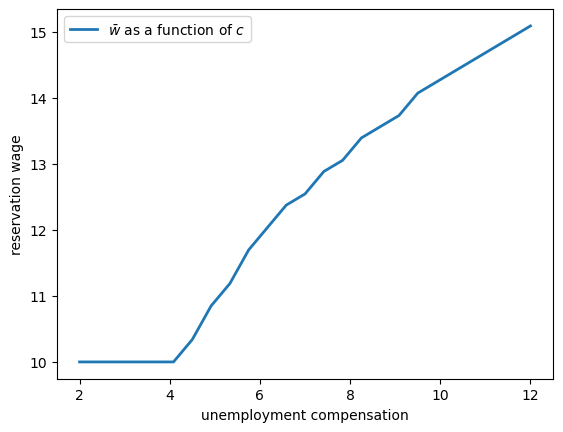)

  
As expected, higher unemployment compensation causes the worker to hold out for higher wages.

In effect, the cost of continuing job search is reduced.

### The reservation wage and discounting

Next, let’s investigate how $ \bar w $ varies with the discount factor.

The next figure plots the reservation wage associated with different values of
$ \beta $

![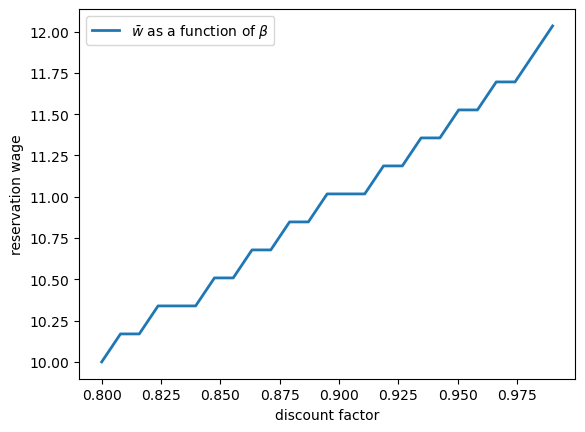](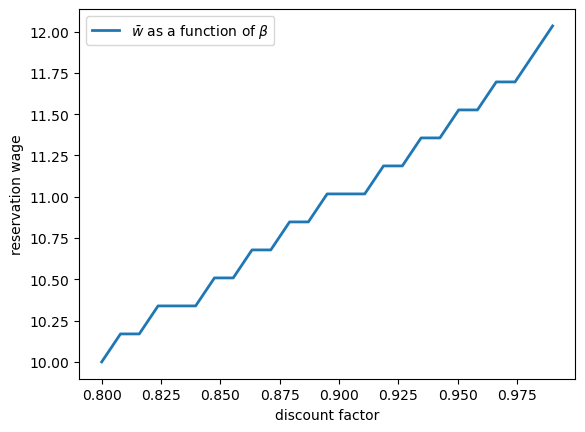)

  
Again, the results are intuitive: More patient workers will hold out for higher wages.

### The reservation wage and job destruction

Finally, let’s look at how $ \bar w $ varies with the job separation rate $ \alpha $.

Higher $ \alpha $ translates to a greater chance that a worker will face termination in each period once employed.

![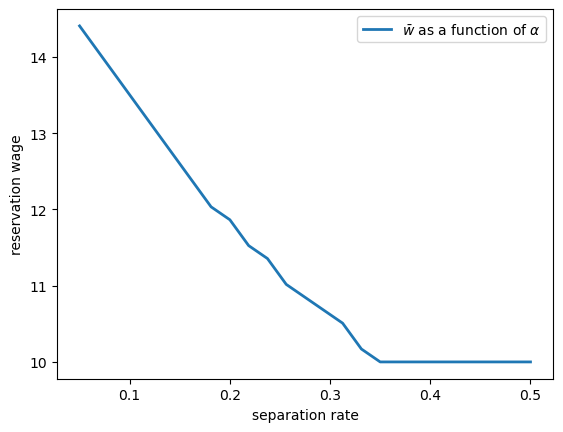](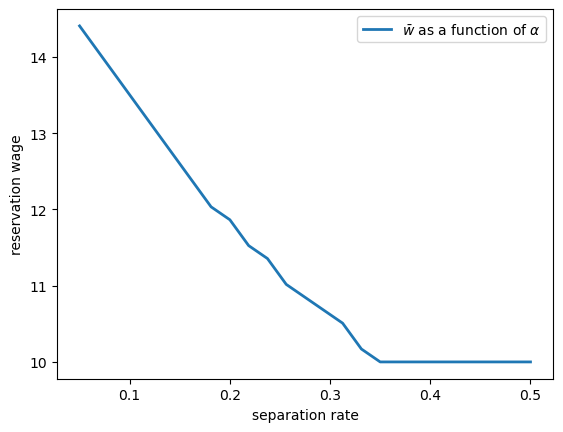)

  
Once more, the results are in line with our intuition.

If the separation rate is high, then the benefit of holding out for a higher wage falls.

Hence the reservation wage is lower.

## Exercises

## Exercise 43.1

Reproduce all the reservation wage figures shown above.

Regarding the values on the horizontal axis, use

In [ ]:
grid_size = 25
c_vals = jnp.linspace(2, 12, grid_size)         # unemployment compensation
β_vals = jnp.linspace(0.8, 0.99, grid_size)     # discount factors
α_vals = jnp.linspace(0.05, 0.5, grid_size)     # separation rate

## Solution

Here’s the first figure.

In [ ]:
def compute_res_wage_given_c(c):
    model = Model(c=c)
    w_bar = compute_reservation_wage(model)
    return w_bar

w_bar_vals = jax.vmap(compute_res_wage_given_c)(c_vals)

fig, ax = plt.subplots()
ax.set(xlabel='unemployment compensation', ylabel='reservation wage')
ax.plot(c_vals, w_bar_vals, lw=2, label=r'$\bar w$ as a function of $c$')
ax.legend()
glue("mccall_resw_c", fig, display=False)
plt.show()

Here’s the second one.

In [ ]:
def compute_res_wage_given_beta(β):
    model = Model(β=β)
    w_bar = compute_reservation_wage(model)
    return w_bar

w_bar_vals = jax.vmap(compute_res_wage_given_beta)(β_vals)

fig, ax = plt.subplots()
ax.set(xlabel='discount factor', ylabel='reservation wage')
ax.plot(β_vals, w_bar_vals, lw=2, label=r'$\bar w$ as a function of $\beta$')
ax.legend()
glue("mccall_resw_beta", fig, display=False)
plt.show()

Here’s the third.

In [ ]:
def compute_res_wage_given_alpha(α):
    model = Model(α=α)
    w_bar = compute_reservation_wage(model)
    return w_bar

w_bar_vals = jax.vmap(compute_res_wage_given_alpha)(α_vals)

fig, ax = plt.subplots()
ax.set(xlabel='separation rate', ylabel='reservation wage')
ax.plot(α_vals, w_bar_vals, lw=2, label=r'$\bar w$ as a function of $\alpha$')
ax.legend()
glue("mccall_resw_alpha", fig, display=False)
plt.show()